In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import gc
import h5py
import wandb
from dotenv import load_dotenv
from wandb.integration.keras import WandbCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau



In [2]:
load_dotenv()  # Load environment variables from .env file
api_key = os.getenv("WANDB_API_KEY")

wandb.login(key=api_key)  # Login with the API key
wandb_project = "FER_Model"
wandb_username = os.getenv("WANDB_USERNAME")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nicholas66. Use `wandb login --relogin` to force relogin


# Load Images

In [3]:
def load_data(hdf5_file, dataset_name_images, dataset_name_labels):
    with h5py.File(hdf5_file, 'r') as hf:
        data = np.array(hf[dataset_name_images])
        labels = np.array(hf[dataset_name_labels])
    return data, labels

# Load data
data, labels = load_data('output files/fer2013_processed.h5', 'fer2013_images', 'fer2013_labels')

# Print shapes to verify
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

# Ensure that data and labels are not empty
assert len(data) > 0, "Data is empty."
assert len(labels) > 0, "Labels are empty."

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    data, 
    labels, 
    test_size=0.2, 
    stratify=labels
)

# Print shapes of the split data
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

Data shape: (28709, 224, 224, 3)
Labels shape: (28709,)
Training data shape: (22967, 224, 224, 3)
Training labels shape: (22967,)
Validation data shape: (5742, 224, 224, 3)
Validation labels shape: (5742,)


# Augmentation

In [4]:
# Define the data augmentation transformations
train_datagen = ImageDataGenerator(
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,           # Randomly apply shearing transformation
    zoom_range=0.2,            # Randomly zoom images by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Strategy for filling in newly created pixels
)

# Create data generator for training data
train_generator = train_datagen.flow(
    X_train,   # Training images
    y_train,   # Training labels
    batch_size=64  # Batch size for training
)

validation_datagen = ImageDataGenerator()

# Create data generator for validation data
validation_generator = validation_datagen.flow(
    X_val,  # Validation images
    y_val,  # Validation labels
    batch_size=64   # Batch size for validation
)


In [5]:
# Check if train_generator yields data correctly
for data_batch, label_batch in train_generator:
    print(f"Data batch shape: {data_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    break  # Only need to check one batch

# Check if validation_generator yields data correctly
for data_batch, label_batch in validation_generator:
    print(f"Data batch shape: {data_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    break  # Only need to check one batch


Data batch shape: (64, 224, 224, 3)
Label batch shape: (64,)
Data batch shape: (64, 224, 224, 3)
Label batch shape: (64,)


In [6]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor, e.g., validation loss
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=5,          # Number of epochs with no improvement before reducing LR
    min_lr=1e-8,         # Lower bound for the learning rate
)

In [7]:
# from tensorflow.keras.callbacks import LearningRateScheduler

# def scheduler(epoch, lr):
#     if epoch > 0 and epoch % 15 == 0:  # Every 20 epochs
#         return lr * 0.5                # Reduce LR by factor of 0.5
#     return lr

# reduce_lr = LearningRateScheduler(scheduler, verbose=1)

# Training CLCM Model

In [ ]:
def create_CLCM_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
   
    for layer in base_model.layers[:2]:  # Adjust the range as needed
        layer.trainable = False
    
    # Build the custom top layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')  # Assuming 7 emotion classes
    ])
    
    return model

# Create the model
model_CLCM = create_CLCM_model()

# Compile the model
model_CLCM.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
    metrics=['accuracy']
)


In [9]:

# wandb.init(project=wandb_project, entity=wandb_username, name="CLCM_Model_Run")
# # Add wandb config updates for CLCM Model

# history = model_CLCM.fit(
#     train_generator,
#     epochs=50,
#     validation_data=validation_generator,  
#     callbacks=[WandbCallback()]
# )


Epoch 1/50


n:\Thesis 2\Code\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2022s 2s/step - accuracy: 0.3254 - loss: 1.7297 - val_accuracy: 0.2936 - val_loss: 2.1809
Epoch 2/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1988s 2s/step - accuracy: 0.4398 - loss: 1.5134 - val_accuracy: 0.1662 - val_loss: 1.8872
Epoch 3/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2039s 2s/step - accuracy: 0.4851 - loss: 1.3940 - val_accuracy: 0.1872 - val_loss: 2.3137
Epoch 4/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2064s 2s/step - accuracy: 0.5128 - loss: 1.3248 - val_accuracy: 0.2732 - val_loss: 2.7865
Epoch 5/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2083s 2s/step - accuracy: 0.4982 - loss: 1.3712 - val_accuracy: 0.3433 - val_loss: 1.8276
Epoch 6/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2099s 2s/step - accuracy: 0.5376 - loss: 1.2762 - val_accuracy: 0.4101 - val_loss: 1.4988
Epoch 7/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2098s 2s/step - accuracy: 0.5588 - loss: 1.2160 - val_accuracy: 0.4887 - val_loss: 1.4883
Epoch 8/50
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1937s 2s/step - accuracy: 0.5626 - loss: 1.21

In [11]:
model_CLCM.save('Trained Model/CLCM_model.keras')

# Training MobileNetV3 Small Model

In [ ]:

wandb.init(project=wandb_project, entity=wandb_username, name="MBNSmall-TL")
def create_MobileNetV3Small_model():
    # Load MobileNetV3Small without the top layers
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:  
        layer.trainable = True
    # Add custom top layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(7, activation='softmax')  # Adjust the number of classes here
    ])
    
    return model

# Create the model
model_MobileNetV3Small = create_MobileNetV3Small_model()

# Compile the model
model_MobileNetV3Small.compile(
    optimizer=Adam(learning_rate=1e-4), # 1e-4 for small
    loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
    metrics=['accuracy']
)

In [7]:
history = model_MobileNetV3Small.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[WandbCallback(save_graph=False, save_model=False), reduce_lr]  
)

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/100


n:\Thesis 2\Code\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 2:18:27 23s/step - accuracy: 0.1250 - loss: 2.607 ━━━━━━━━━━━━━━━━━━━━ 7:32 1s/step - accuracy: 0.1250 - loss: 2.5681    ━━━━━━━━━━━━━━━━━━━━ 8:13 1s/step - accuracy: 0.1233 - loss: 2.546 ━━━━━━━━━━━━━━━━━━━━ 8:37 1s/step - accuracy: 0.1198 - loss: 2.539 ━━━━━━━━━━━━━━━━━━━━ 8:32 1s/step - accuracy: 0.1190 - loss: 2.526 ━━━━━━━━━━━━━━━━━━━━ 8:34 1s/step - accuracy: 0.1174 - loss: 2.518 ━━━━━━━━━━━━━━━━━━━━ 8:33 1s/step - accuracy: 0.1159 - loss: 2.513 ━━━━━━━━━━━━━━━━━━━━ 8:23 1s/step - accuracy: 0.1163 - loss: 2.504 ━━━━━━━━━━━━━━━━━━━━ 8:15 1s/step - accuracy: 0.1177 - loss: 2.496 ━━━━━━━━━━━━━━━━━━━━ 8:08 1s/step - accuracy: 0.1189 - loss: 2.488 ━━━━━━━━━━━━━━━━━━━━ 8:07 1s/step - accuracy: 0.1211 - loss: 2.477 ━━━━━━━━━━━━━━━━━━━━ 8:06 1s/step - accuracy: 0.1229 - loss: 2.469 ━━━━━━━━━━━━━━━━━━━━ 8:05 1s/step - accuracy: 0.1246 - loss: 2.462 ━━━━━━━━━━━━━━━━━━━━ 8:03 1s/step - accuracy: 0.1262 - loss: 2.455 ━━━━━━━━━━━━━━━━━━━━ 8:03 1s/step - accuracy: 

In [8]:
model_MobileNetV3Small.save('Trained Model/MobileNetV3Small_with_TL.keras')


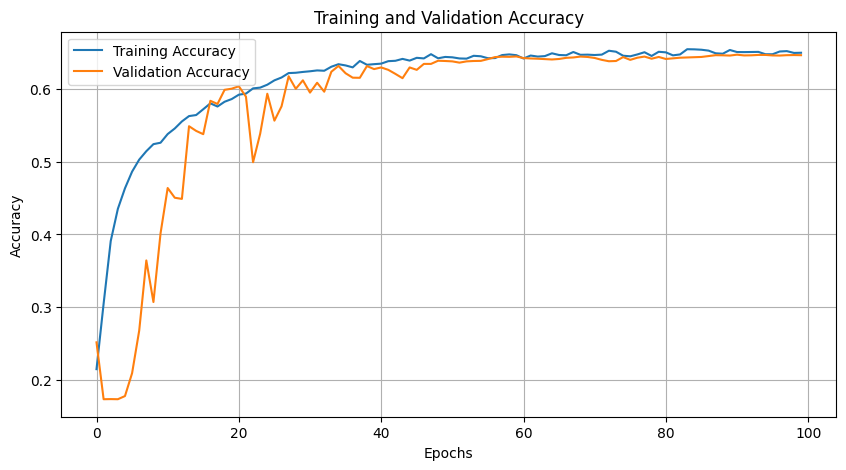

In [9]:
import matplotlib.pyplot as plt 
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))  # Create a new figure for the plot
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Show legend
plt.grid()  # Show grid
plt.show()  # Display the plot

## Training MobileNetV3 Large

In [8]:
wandb.init(project=wandb_project, entity=wandb_username, name="MBNLarge")
def create_MobileNetV3_model():
    # Load MobileNetV3Small without the top layers
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:  # Adjust the range as needed
        layer.trainable = True

    # Add custom top layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(7, activation='softmax')  # Adjust the number of classes here
    ])
    
    return model

# Create the model
model_MobileNetV3 = create_MobileNetV3_model()

# Compile the model
model_MobileNetV3.compile(
    optimizer=Adam(learning_rate=5e-5), # 1e-4 for small
    loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
    metrics=['accuracy']
)

In [9]:
history = model_MobileNetV3.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[WandbCallback(save_graph=False, save_model=False), reduce_lr]  
)

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/100


n:\Thesis 2\Code\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 3:09:22 32s/step - accuracy: 0.1719 - loss: 2.191 ━━━━━━━━━━━━━━━━━━━━ 20:24 3s/step - accuracy: 0.1562 - loss: 2.2175  ━━━━━━━━━━━━━━━━━━━━ 21:30 4s/step - accuracy: 0.1458 - loss: 2.23 ━━━━━━━━━━━━━━━━━━━━ 21:38 4s/step - accuracy: 0.1426 - loss: 2.23 ━━━━━━━━━━━━━━━━━━━━ 21:37 4s/step - accuracy: 0.1409 - loss: 2.23 ━━━━━━━━━━━━━━━━━━━━ 21:50 4s/step - accuracy: 0.1413 - loss: 2.23 ━━━━━━━━━━━━━━━━━━━━ 21:42 4s/step - accuracy: 0.1422 - loss: 2.22 ━━━━━━━━━━━━━━━━━━━━ 21:35 4s/step - accuracy: 0.1437 - loss: 2.22 ━━━━━━━━━━━━━━━━━━━━ 21:40 4s/step - accuracy: 0.1449 - loss: 2.21 ━━━━━━━━━━━━━━━━━━━━ 21:35 4s/step - accuracy: 0.1451 - loss: 2.21 ━━━━━━━━━━━━━━━━━━━━ 21:28 4s/step - accuracy: 0.1456 - loss: 2.20 ━━━━━━━━━━━━━━━━━━━━ 21:20 4s/step - accuracy: 0.1462 - loss: 2.20 ━━━━━━━━━━━━━━━━━━━━ 21:14 4s/step - accuracy: 0.1468 - loss: 2.20 ━━━━━━━━━━━━━━━━━━━━ 21:10 4s/step - accuracy: 0.1474 - loss: 2.19 ━━━━━━━━━━━━━━━━━━━━ 21:07 4s/step - accuracy: 

In [10]:
model_MobileNetV3.save('Trained Model/MobileNetV3Large.keras')


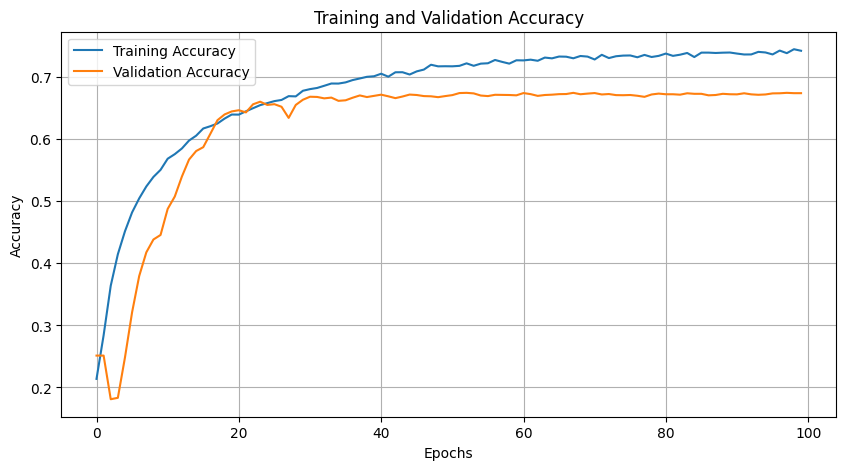

In [11]:
import matplotlib.pyplot as plt 
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))  # Create a new figure for the plot
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Show legend
plt.grid()  # Show grid
plt.show()  # Display the plot

# 2nd Part: Model Testing

In [ ]:
LEC_loaded_model = tf.keras.models.load_model('Trained Model/LEC_model.keras')

In [ ]:
def moodNamePrintFromLabel(n):
  if n == 0: result = 'Angry '
  elif n == 1: result = 'Disgust '
  elif n == 2: result = 'Fear'
  elif n == 3: result = 'Happy'
  elif n == 4: result = 'Sad'
  elif n == 5: result = 'Surprise'
  elif n == 6: result = 'Neutral'
  return result

In [13]:

import urllib.request

# URL to download the Haar cascade XML file
url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'

# Path to save the downloaded XML file
xml_file_path = 'haarcascade_frontalface_default.xml'

# Download the XML file
urllib.request.urlretrieve(url, xml_file_path)

print("Haar cascade XML file downloaded successfully.")


Haar cascade XML file downloaded successfully.


In [14]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt


face_casecade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


def videoToMoodDetection(video_path):
  #video_cap = cv2.VideoCapture(0)
  video_cap = cv2.VideoCapture(video_path)

  while (video_cap.isOpened()):
    ret, frame = video_cap.read()

    Gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_casecade.detectMultiScale(Gray_img, 1.3, 5)

    for (x, y, w, h) in faces:
      single_face = Gray_img[y:y+h, x:x+w]  # Extract face region

      # Convert single_face to RGB if it is grayscale
      if len(single_face.shape) == 2:  # Check if the image is grayscale
        single_face = cv2.cvtColor(single_face, cv2.COLOR_GRAY2RGB)

      resized_img = cv2.resize(single_face, (224, 224), interpolation=cv2.INTER_AREA)
      #printing the 48*48 pixel images which will be passed to the model
      plt.imshow(resized_img, cmap='gray')
      plt.show()

      #resize for passing to the model
      resized_img = np.reshape(resized_img, (1, 224, 224, 3)) / 255.0

      #passing to model
      result = np.argmax(LEC_loaded_model.predict(resized_img), axis=-1)
      if result is not None:
        print(moodNamePrintFromLabel(result))



def imageToMoodDetection(img_path):

  img = cv2.imread(img_path)

  Gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_casecade.detectMultiScale(Gray_img, 1.3, 3)

  for (x, y, w, h) in faces:
    single_face = Gray_img[y:y+h, x:x+w]  # Extract face region

    # Convert single_face to RGB if it is grayscale
    if len(single_face.shape) == 2:  # Check if the image is grayscale
      single_face = cv2.cvtColor(single_face, cv2.COLOR_GRAY2RGB)

    resized_img = cv2.resize(single_face, (224, 224), interpolation=cv2.INTER_AREA)
    plt.imshow(resized_img)
    plt.show()      
    print(resized_img.shape)
    resized_img = np.reshape(resized_img, (1, 224, 224, 3)) / 255.0

      #passing to model
    result = np.argmax(LEC_loaded_model.predict(resized_img), axis=-1)
    if result is not None:
      print(moodNamePrintFromLabel(result))



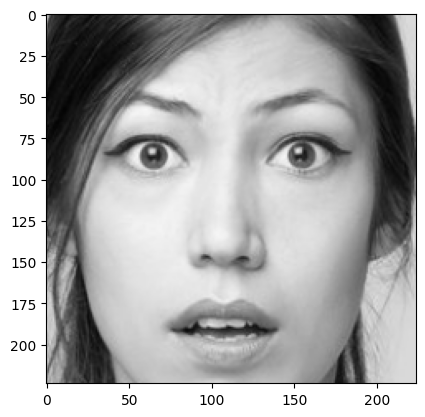

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
fear


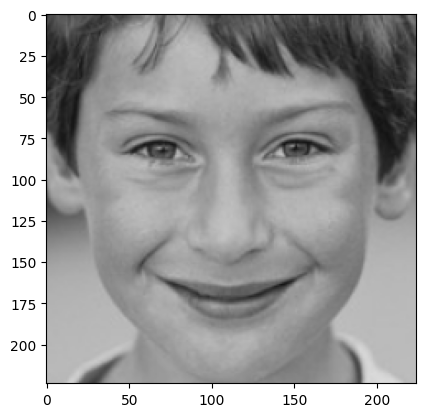

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
happy


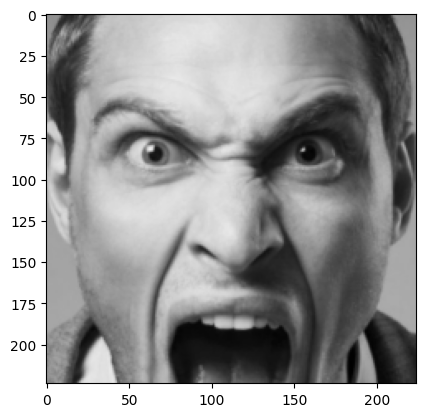

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
angry 


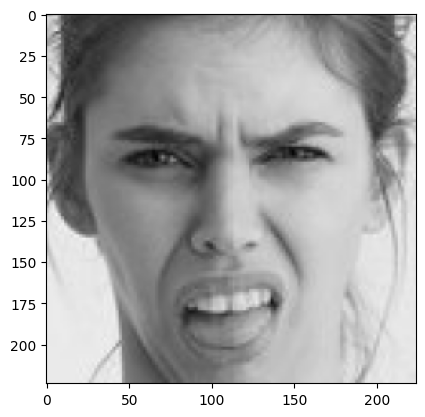

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
angry 


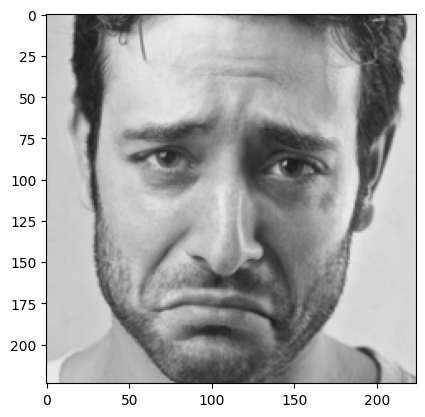

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
sad


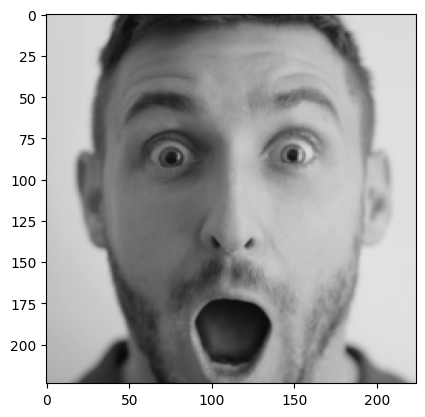

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
fear


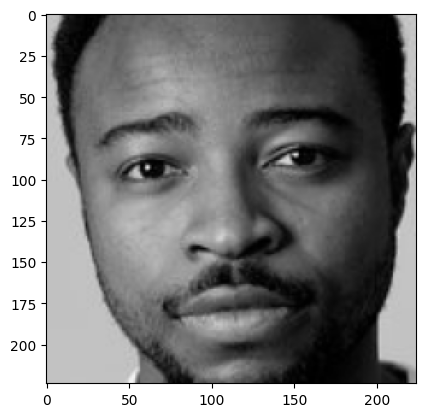

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
neutral


In [15]:
import cv2

# Load the image
imageToMoodDetection('Test image/Testing1.jpg')
imageToMoodDetection('Test image/Testing2.jpg')
imageToMoodDetection('Test image/Testing3.jpg')
imageToMoodDetection('Test image/Testing4.jpg')
imageToMoodDetection('Test image/Testing5.webp')
imageToMoodDetection('Test image/Testing6.jpg')
imageToMoodDetection('Test image/Testing7.jpg')







In [ ]:
import tensorflowjs as tfjs
import tensorflow as tf

# Load your Keras model
model = tf.keras.models.load_model('Trained Model/CLCM_model.keras')

# Convert and save the model
tfjs.converters.save_keras_model(model, 'Trained Model/FER_model_tfjs')
